In [1]:
from google.colab import files
files.upload()
files.upload()

Saving data_handler.py to data_handler.py


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevandong","key":"c7ea20330645c70af3ad4bf050e88abf"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle --version

Kaggle API 1.6.17


In [3]:
!kaggle competitions download -c deep-learning-spring-2025-project-1
!unzip -q deep-learning-spring-2025-project-1.zip -d ./data

 98% 185M/189M [00:01<00:00, 163MB/s]
100% 189M/189M [00:01<00:00, 157MB/s]


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from data_handler import DataHandler
import numpy as np
import torch.nn.functional as F

In [5]:
# 数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, data_handler, files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for file in files:
            batch = data_handler.unpickle(file)
            images = batch[b"data"].reshape(-1, 3, 32, 32).astype(np.uint8)
            labels = batch[b"labels"]
            self.data.append(images)
            self.labels.extend(labels)

        self.data = np.vstack(self.data)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.transpose(image, (1, 2, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

data_handler = DataHandler("./data/cifar-10-python/cifar-10-batches-py/")
train_files = [f"data_batch_{i}" for i in range(1, 6)]
test_files = ["test_batch"]

train_dataset = CIFAR10Dataset(data_handler, train_files, transform=transform)
test_dataset = CIFAR10Dataset(data_handler, test_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# CIFAR-10 文件路径
DATA_DIR = './data/cifar-10-python/cifar-10-batches-py'

# 定义函数来解压 CIFAR-10 文件
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
        data = data_dict[b'data']
        labels = data_dict[b'labels']
        data = data.reshape(-1, 3, 32, 32).astype('float32') / 255.0  # 归一化到 [0, 1]
        labels = np.array(labels)
        return data, labels

# 加载训练集（5个 batch 文件合并）
train_data = []
train_labels = []

for i in range(1, 6):
    file = os.path.join(DATA_DIR, f'data_batch_{i}')
    data, labels = load_cifar_batch(file)
    train_data.append(data)
    train_labels.append(labels)

# 合并训练数据
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# 加载测试集
test_file = os.path.join(DATA_DIR, 'test_batch')
test_data, test_labels = load_cifar_batch(test_file)

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Testing labels shape: {test_labels.shape}")

class CIFARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        # 将 numpy 数组转换为 tensor
        image = torch.tensor(image, dtype=torch.float)
        return image, label

# 创建数据集
train_dataset = CIFARDataset(train_data, train_labels)
test_dataset = CIFARDataset(test_data, test_labels)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# 打印 DataLoader 取样
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")  # [128, 3, 32, 32]
    print(f"Batch labels shape: {labels.shape}")  # [128]
    break

Training data shape: (50000, 3, 32, 32)
Training labels shape: (50000,)
Testing data shape: (10000, 3, 32, 32)
Testing labels shape: (10000,)
Batch images shape: torch.Size([128, 3, 32, 32])
Batch labels shape: torch.Size([128])


In [6]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # Using 3x3 square kernel, padding=1 ensure that the output size is the same as the input size.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.sample = None
    if stride != 1 or in_channels != out_channels:
      self.sample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
        nn.BatchNorm2d(out_channels)
            )

  def forward(self, x):
    residualx = x
    if self.sample is not None:
      residualx = self.sample(x)

    out = self.conv1(x)
    out = self.bn1(out)
    out = nn.ReLU(inplace=True)(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out += residualx
    out = nn.ReLU(inplace=True)(out)

    return out

In [7]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 50, layers[0])
    self.layer2 = self._make_layer(block, 100, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 200, layers[2], stride=2)
    # self.layer4 = self._make_layer(block, 336, layers[3], stride=2)
    self.layer4 = self._make_layer(block, 200, layers[3], stride=2)
    self.layer5 = self._make_layer(block, 200, layers[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    # self.fc = nn.Linear(336, num_classes)
    self.fc_1 = nn.Linear(200, 100)
    self.fc_2 = nn.Linear(100, 50)
    self.fc_3 = nn.Linear(50, num_classes)


  def _make_layer(self, block, out_channels, num_blocks, stride=1):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    # x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.layer5(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    # x = self.fc(x)
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = F.log_softmax(x, dim=1)

    return x

In [8]:
layers = [2, 2, 2, 2]
model = ResNet(ResidualBlock, layers).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [9]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 50, 224, 224]           3,250
       BatchNorm2d-5         [-1, 50, 224, 224]             100
            Conv2d-6         [-1, 50, 224, 224]          28,850
       BatchNorm2d-7         [-1, 50, 224, 224]             100
            Conv2d-8         [-1, 50, 224, 224]          22,550
       BatchNorm2d-9         [-1, 50, 224, 224]             100
    ResidualBlock-10         [-1, 50, 224, 224]               0
           Conv2d-11         [-1, 50, 224, 224]          22,550
      BatchNorm2d-12         [-1, 50, 224, 224]             100
           Conv2d-13         [-1, 50, 224, 224]          22,550
      BatchNorm2d-14         [-1, 50, 2

In [10]:
import matplotlib.pyplot as plt
import torch

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

# 训练循环
num_epochs = 200
record_interval = 5  # 每10个 epoch 记录一次

for epoch in range(num_epochs):
    train_running_loss = 0.0
    test_running_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_test = 0
    total_test = 0

    # === 训练阶段 ===
    model.train()
    train_running_loss = 0.0
    for i, data in enumerate(train_loader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model(images)
        loss = criterion(predicted_output, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

        _, predicted = torch.max(predicted_output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # === 测试阶段 ===
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model(images)
            loss = criterion(predicted_output, labels)
            test_running_loss += loss.item()

            _, predicted = torch.max(predicted_output, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    # === 计算平均损失和准确率 ===
    train_loss = train_running_loss / len(train_loader)
    test_loss = test_running_loss / len(test_loader)

    train_accuracy = correct_train / total_train * 100
    test_accuracy = correct_test / total_test * 100

    # === 每10个 epoch 记录一次 ===
    if (epoch + 1) % record_interval == 0:
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | '
              f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')

Epoch [5/200] | Train Loss: 1.1528 | Train Accuracy: 60.04% | Test Loss: 1.2150 | Test Accuracy: 58.41%
Epoch [10/200] | Train Loss: 0.9030 | Train Accuracy: 67.51% | Test Loss: 0.9351 | Test Accuracy: 66.55%
Epoch [15/200] | Train Loss: 0.7968 | Train Accuracy: 70.61% | Test Loss: 0.8458 | Test Accuracy: 68.92%
Epoch [20/200] | Train Loss: 0.7375 | Train Accuracy: 72.38% | Test Loss: 0.8623 | Test Accuracy: 69.05%
Epoch [25/200] | Train Loss: 0.6989 | Train Accuracy: 73.33% | Test Loss: 0.7733 | Test Accuracy: 71.04%
Epoch [30/200] | Train Loss: 0.4574 | Train Accuracy: 82.84% | Test Loss: 0.5641 | Test Accuracy: 79.59%
Epoch [35/200] | Train Loss: 0.4255 | Train Accuracy: 83.85% | Test Loss: 0.5384 | Test Accuracy: 80.33%
Epoch [40/200] | Train Loss: 0.1813 | Train Accuracy: 93.93% | Test Loss: 0.3478 | Test Accuracy: 89.15%
Epoch [45/200] | Train Loss: 0.1651 | Train Accuracy: 94.33% | Test Loss: 0.3566 | Test Accuracy: 88.68%
Epoch [50/200] | Train Loss: 0.1605 | Train Accuracy: 94

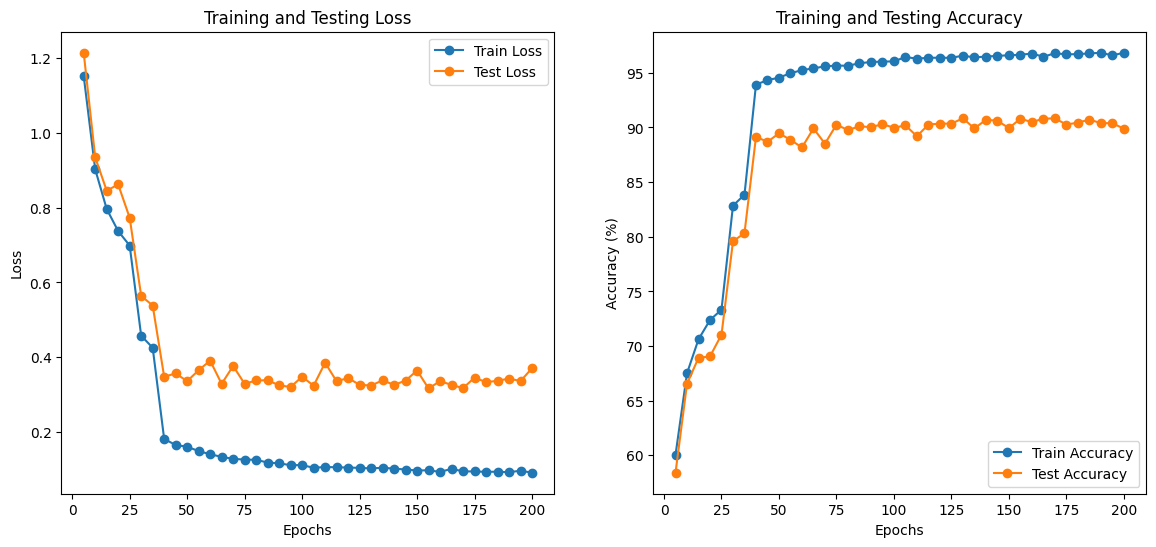

In [11]:
# === 绘制曲线 ===
def plot_results(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history):
    epochs_recorded = list(range(record_interval, num_epochs + 1, record_interval))

    plt.figure(figsize=(14, 6))

    # 绘制 Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_recorded, train_loss_history, label='Train Loss', marker='o')
    plt.plot(epochs_recorded, test_loss_history, label='Test Loss', marker='o')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制 Accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_recorded, train_accuracy_history, label='Train Accuracy', marker='o')
    plt.plot(epochs_recorded, test_accuracy_history, label='Test Accuracy', marker='o')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# === 调用绘图函数 ===
plot_results(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history)

In [12]:
import pickle
import torch
import pandas as pd

with open('./data/cifar_test_nolabel.pkl', 'rb') as f:
    data = pickle.load(f)

print(f"Data type: {type(data)}")

images = data[b'data'].transpose(0, 3, 1, 2)
ids = data[b'ids']
images = torch.from_numpy(images).float().cuda()

model.eval()
with torch.no_grad():
    predicted_output = model(images)
    _, predictions = torch.max(predicted_output, 1)

df = pd.DataFrame({
    'ID': ids,
    'Predicted_Label': predictions.cpu().numpy()
})

csv_file = 'predictions.csv'
df.to_csv(csv_file, index=False)

print(f"Predictions saved to {csv_file}")

Data type: <class 'dict'>
Predictions saved to predictions.csv


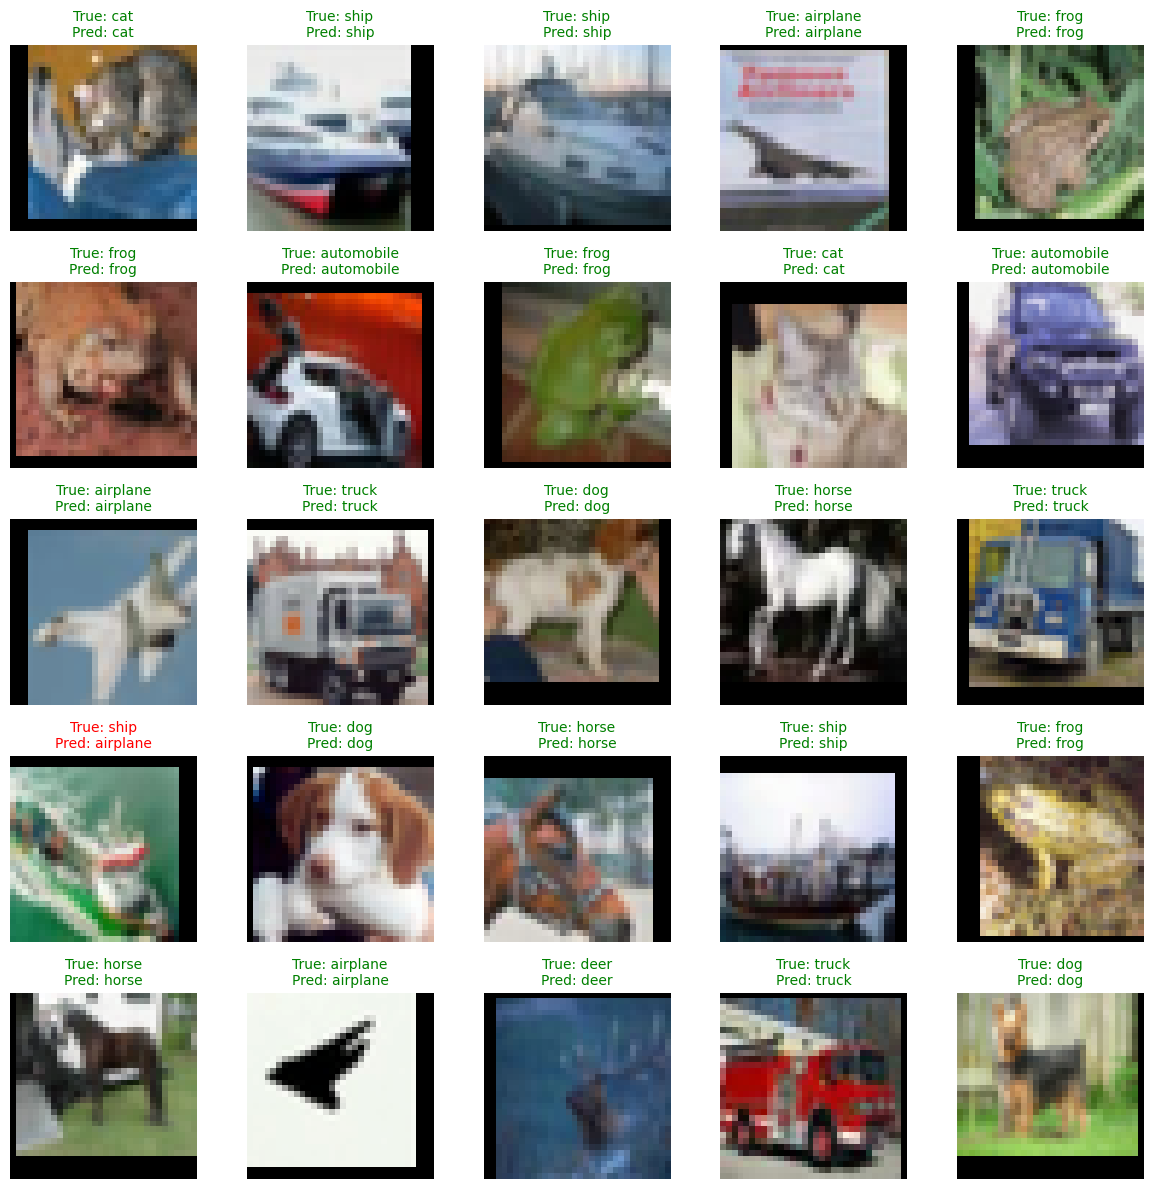

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

num_images = 25
selected_images, selected_labels = zip(*[test_dataset[i] for i in range(num_images)])

selected_images = torch.stack(selected_images).to('cuda' if torch.cuda.is_available() else 'cpu')
selected_labels = torch.tensor(selected_labels).to('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted_labels = torch.max(outputs, 1)

selected_images = selected_images.cpu().numpy()
selected_labels = selected_labels.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()

import pickle
with open('./data/cifar-10-python/cifar-10-batches-py/batches.meta', 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
label_names = [name.decode('utf-8') for name in meta[b'label_names']]

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.247, 0.243, 0.261])

def denormalize(img):
    img = img * std[:, None, None] + mean[:, None, None]
    img = np.clip(img, 0, 1)
    return img

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = selected_images[i]
    img = denormalize(img)
    img = img.transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)

    true_label = label_names[selected_labels[i]]
    pred_label = label_names[predicted_labels[i]]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                 fontsize=10,
                 color="green" if true_label == pred_label else "red")
    ax.axis("off")

plt.tight_layout()
plt.show()
